In [1351]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee
import pandas as pd
from scipy import integrate

In [1352]:
us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [1353]:
def raw_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:] # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:] # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    return df

def smooth_data(state,window = 10):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:].diff()  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:].diff()  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    df = df.rolling(window=window).mean() # rolling mean window to smoothen out data
    df = df[window:].round()
    df = df.clip(lower = 1)
    return df

In [1354]:
colorado = smooth_data('Colorado')

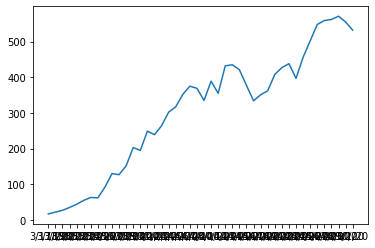

In [1355]:
plt.plot(colorado.confirmed)

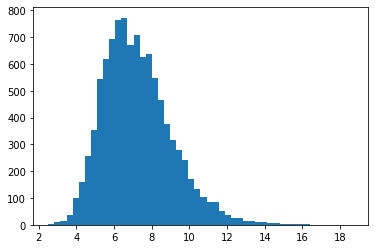

In [1356]:
s, loc, scale = 0.25,0,7
gamma = stats.lognorm.rvs(s,loc,scale,size=10000)
gamma = 1/gamma
plt.hist(1/gamma,bins=50)
plt.show()

In [1357]:
def draw_gamma():
    s, loc, scale = 0.25,0,7
    gamma = stats.lognorm.rvs(s,loc,scale)
    return 1/gamma
    

In [1358]:
r0_grid = np.linspace(0,5,num=1000)

In [1359]:
# predict new cases today, given yesterday's cases,gamma,effective R
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out



In [1360]:
def r0_lhood(r0,gamma,yest_nc,today_nc,tol = 1e-6):
    prediction = newcases(yest_nc,gamma,r0)
    lhood = stats.poisson.logpmf(today_nc,prediction + tol)
    return lhood

Makes sense, Now do it for colorado....

In [1361]:
def bayes_update(confirmed_vals,gamma,sigma=0.0):
    # Compute likelihoods
    likehoods = []
    for i in range(len(colorado)-1):
        yesterday = colorado.confirmed.values[i]
        today = colorado.confirmed.values[i+1]
        pmf = np.e**r0_lhood(r0_grid,gamma,yesterday,today)
        pmf /= np.sum(pmf)
        likehoods.append(pmf)
    likehoods = np.array(likehoods)
    
   
    posteriors = []
    prior = np.ones(len(r0_grid))/len(r0_grid)

    for i in range(len(colorado) - 1):
        posterior = likehoods[i] * prior
        posterior /= np.sum(posterior)
        posteriors.append(posterior)   
        prior = posterior

    posteriors = np.array(posteriors)
    
    return likehoods,posteriors

In [1362]:
likehoods, posteriors = bayes_update(colorado.confirmed.values,1/7)

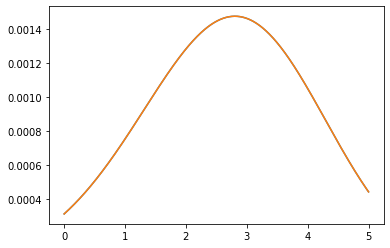

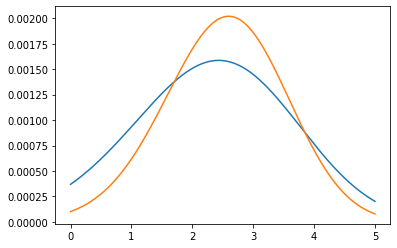

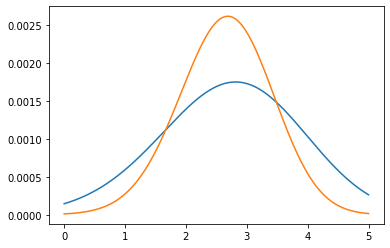

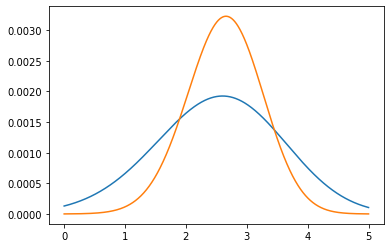

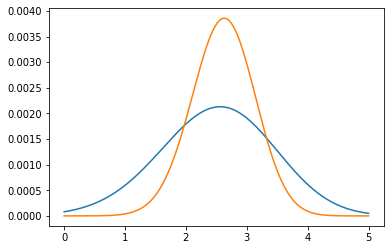

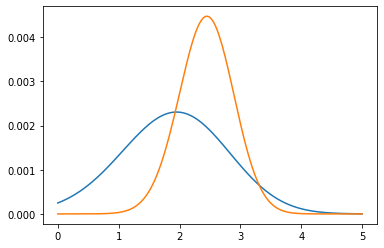

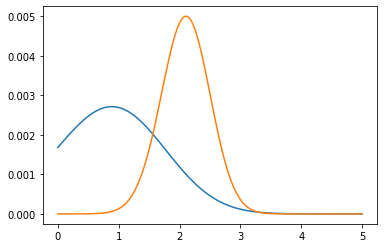

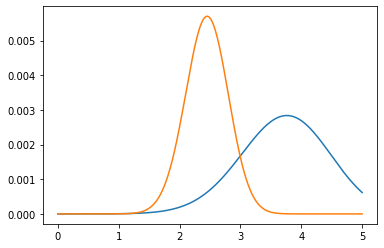

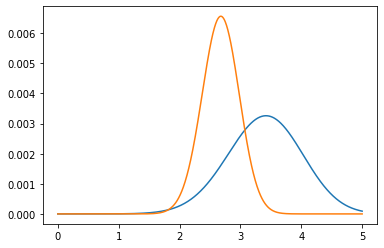

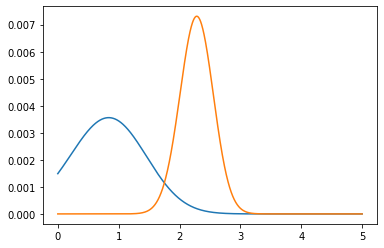

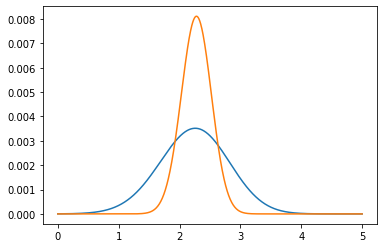

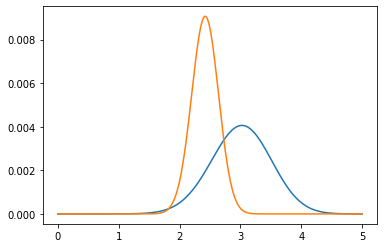

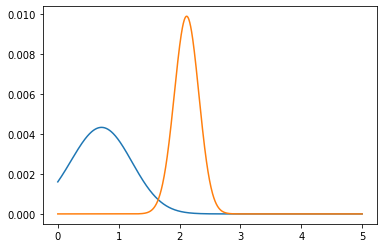

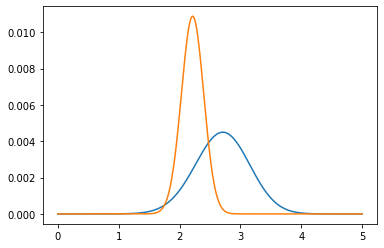

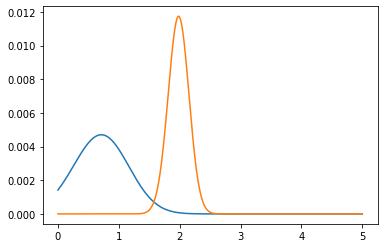

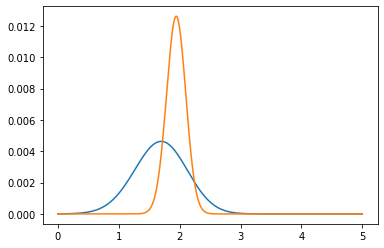

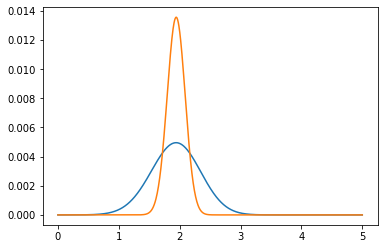

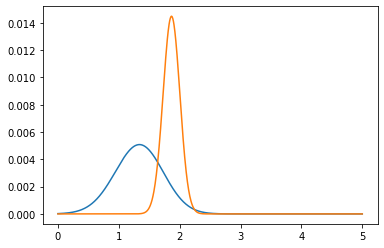

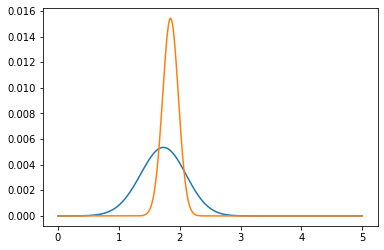

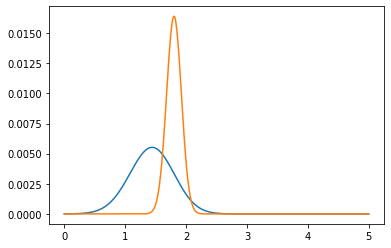

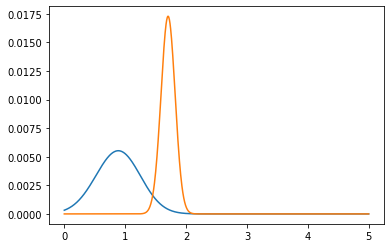

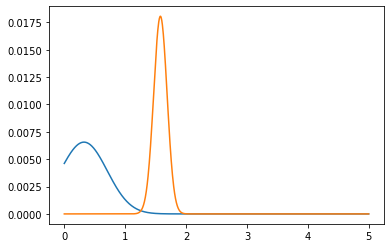

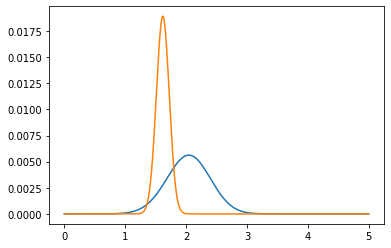

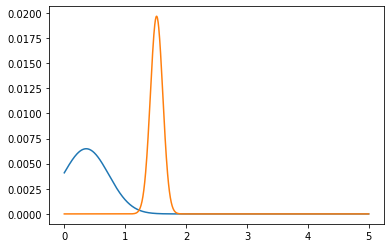

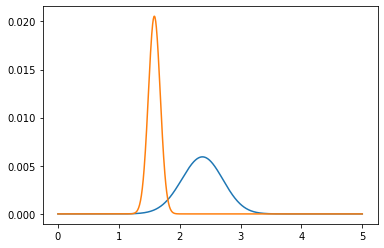

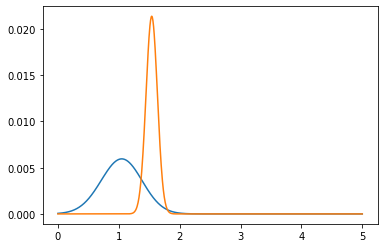

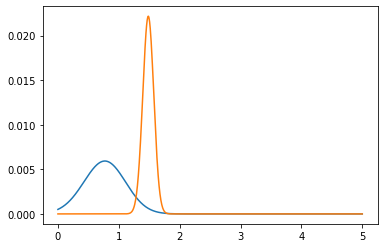

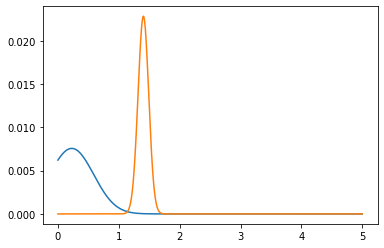

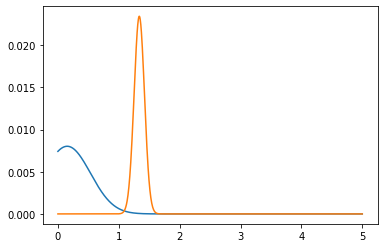

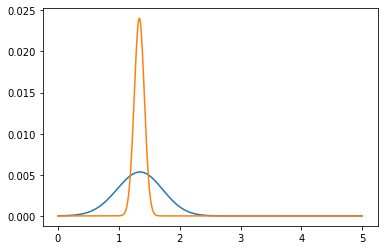

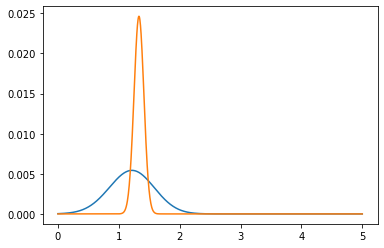

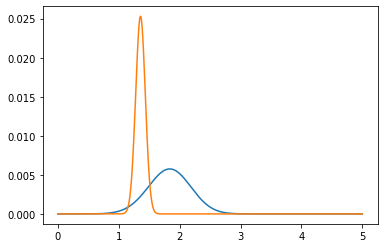

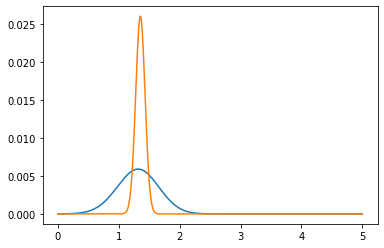

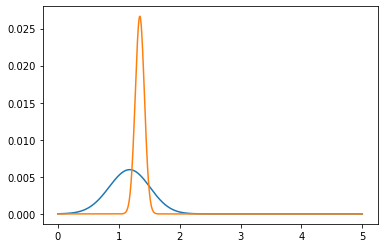

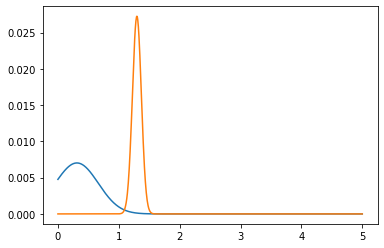

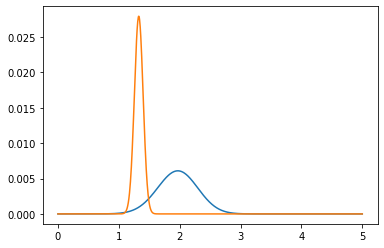

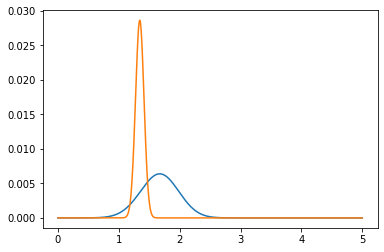

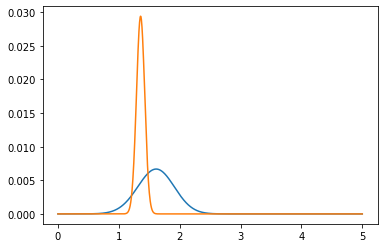

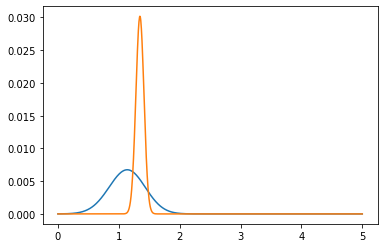

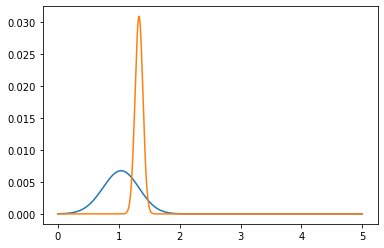

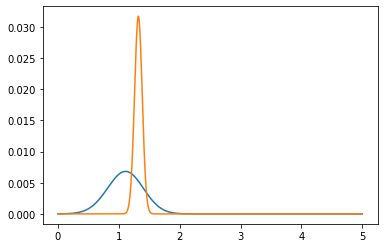

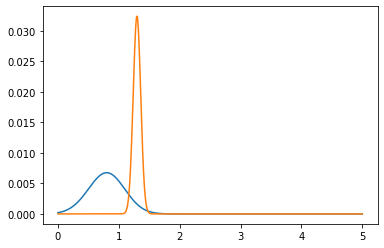

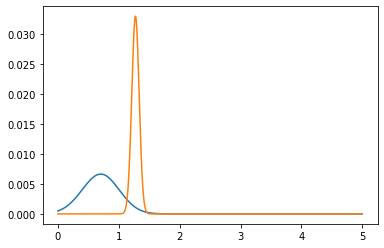

In [1363]:
for i in range(len(likehoods)):  
    plt.plot(r0_grid,likehoods[i])
    plt.plot(r0_grid,posteriors[i])
    plt.savefig('images/'+str(i)+'.png')
    plt.show()

In [1364]:
def mu_std(dist_array):
    mu = np.sum(dist_array * r0_grid)/np.sum(dist_array)
    
    sigma = (r0_grid - mu)**2 * dist_array
    sigma = np.sqrt(np.sum(sigma))
    
    sigma /= np.sum(dist_array)
    
    return mu,sigma


In [1365]:
mu_list = np.zeros(len(posteriors))
std_list = np.zeros(len(posteriors))

for i in range(len(posteriors)):
    mu_list[i],std_list[i] = mu_std(posteriors[i])
    

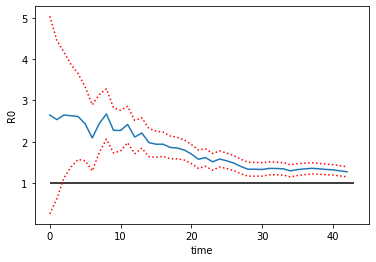

In [1366]:
plt.plot(mu_list)
plt.plot(mu_list + 2*std_list,'r:')
plt.plot(mu_list - 2*std_list,'r:')
plt.hlines(1,0,len(posteriors))
plt.xlabel('time')
plt.ylabel('R0')
plt.show()


In [1367]:

# Now take into effects for all gammas:
current_posterior = np.zeros(len(r0_grid))
current_likehood = np.zeros(len(r0_grid))

for _ in range(100):
    g = draw_gamma()
    l,p = bayes_update(colorado.confirmed.values,g)
    
    # only keep latest estimate of likelihood and posterior
    current_posterior += l[-1]
    current_posterior += p[-1]


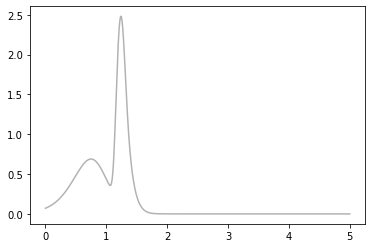

In [1368]:
plt.plot(r0_grid,current_posterior,alpha = 0.3,color = 'black')

Now extrapolate to calculate number of cases at current value of R0

In [1369]:
cdf = integrate.cumtrapz(current_posterior,x=r0_grid,)
u = np.random.rand()

loc = np.argmin(np.abs(cdf - u))
r0_grid[loc]

1.2562562562562563

In [1370]:
def draw_r0(posterior,size = 1):
    cdf = integrate.cumtrapz(posterior,x=r0_grid)
    
    samples = np.zeros(size)
    for i in range(size):
        u = np.random.rand()

        loc = np.argmin(np.abs(cdf - u))
        samples[i] = r0_grid[loc]
        
        
    if size == 1: 
        return samples[0]
    else:
        return samples
    

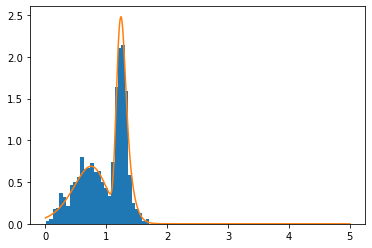

In [1371]:
plt.hist(draw_r0(current_posterior,size=1000),bins=30,density=True)
plt.plot(r0_grid,current_posterior)

In [1372]:
def extrapolate(r,g,days=20):
    proj = [colorado.confirmed[-1]]
    for i in range(days):
        tomorrow = newcases(proj[-1],g,r) # model prediction
        tomorrow = stats.poisson.rvs(tomorrow) # including poisson noise
        proj.append(tomorrow)
    return np.array(proj)
    

In [1373]:
def plot_projections(preds,**kwargs):
    time = np.arange(len(colorado.confirmed))
    plt.plot(time, colorado.confirmed,'ro')
    
    future_time = np.arange(len(time) -1 ,len(time) + len(preds) -1)
    plt.plot(future_time,preds,**kwargs)

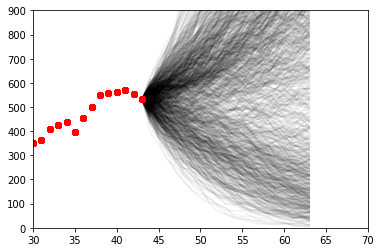

In [1374]:
for _ in range(1000):
    r0 = draw_r0(current_posterior)
    g = draw_gamma()
    plot_projections(extrapolate(r0,g),alpha = 0.05,color = 'black')
    plt.ylim(0,900)
    plt.xlim(30,70)


(array([ 12.,  52., 127., 216., 246., 182., 101.,  50.,  12.,   2.]),
 array([0.0469142 , 0.0480578 , 0.04920141, 0.05034501, 0.05148861,
        0.05263221, 0.05377582, 0.05491942, 0.05606302, 0.05720663,
        0.05835023]),
 <a list of 10 Patch objects>)

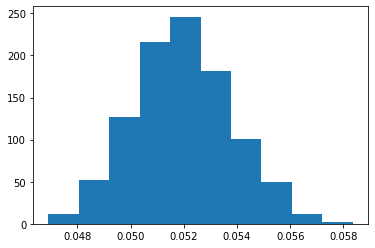

In [1375]:
raw = raw_data('Colorado')
cfr = np.random.poisson(raw.deaths[-1],size = 1000)/np.random.poisson(raw.confirmed[-1],size = 1000)
plt.hist(cfr)

In [1376]:
colorado.confirmed[-1]

532.0

In [1377]:
def death_project(r,g,days = 20):
    cfr = np.random.poisson(raw.deaths[-1])/np.random.poisson(raw.confirmed[-1])
    
    future_cases = extrapolate(r,g,days=20)[1:]
    future_deaths = np.cumsum(future_cases) * cfr 
    future_deaths += raw.deaths[-1]  # add in current death toll
    future_deaths = stats.poisson.rvs(future_deaths)
    
    deaths = np.append(raw.deaths.values,future_deaths)

    return deaths
    

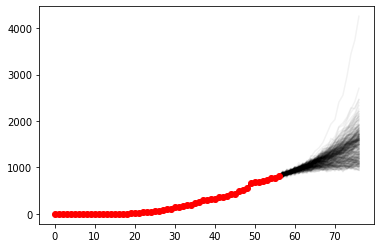

In [1378]:
for i in range(300):
    r = draw_r0(current_posterior)
    g = draw_gamma()
    plt.plot(death_project(r,g),alpha = 0.05,color = 'black')
plt.plot(raw.deaths.values,'ro')

### Is the idea of a process matrix good? Seems like this depends quite significantly on the smoothing
# Play around with the smoothing